# Load data

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import FrameVideoDataset

root_dir = r"ufc10"

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running on: {device}')

# Define transforms for different model types*
transform_pretrained = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_3d = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and loaders for different model types
test_dataset_pretrained = FrameVideoDataset(root_dir=root_dir, split='val', 
                                          transform=transform_pretrained, stack_frames=True)
test_dataset_3d = FrameVideoDataset(root_dir=root_dir, split='val', 
                                   transform=transform_3d, stack_frames=True)

test_loader_pretrained = DataLoader(test_dataset_pretrained, batch_size=8, shuffle=False)
test_loader_3d = DataLoader(test_dataset_3d, batch_size=8, shuffle=False)

Running on: cuda


# Load models

In [2]:
import os
import torch
from aggregation_model import Pretrained
from early_fusion import EarlyFusionModel
from late_fusion import LateFusion
from model3d import TheConvolver3D

# Directory containing the saved model files
models_dir = r"../saved_models/"

# Define the model paths
model_paths = {
    "Aggregation": os.path.join(models_dir, "Pretrained_best.pth"),
    "EarlyFusionModel": os.path.join(models_dir, "EarlyFusionModel_best.pth"),
    "LateFusionAVGPool": os.path.join(models_dir, "LateFusionAVGPool_best.pth"),
    "LateFusionMLP": os.path.join(models_dir, "LateFusionMLP_best.pth"),
    "3DConv": os.path.join(models_dir, "TheConvolver3D_best.pth")
}

hyperparameters = {
    'num_classes': 10,
}


# Initialize the models
models = {
    "Aggregation": Pretrained( pretrained=False, freeze_backbone = False),
    "EarlyFusionModel": EarlyFusionModel(hyperparameters=hyperparameters, load_pretrained=False, use_lstm=False),
    "LateFusionAVGPool": LateFusion(hyperparameters=hyperparameters, load_pretrained=False, fusion_type='avg_pool'),
    "LateFusionMLP": LateFusion(hyperparameters=hyperparameters, load_pretrained=False, fusion_type='mlp'),
    "3DConv": TheConvolver3D()
}

for model_name, model in models.items():
    model_path = model_paths[model_name]
    if os.path.exists(model_path):
        checkpoint = torch.load(model_path)  # Load checkpoint
        model.load_state_dict(checkpoint["model_state_dict"])  # Load model weights
        model.eval()  # Set the model to evaluation mode
        print(f"{model_name} loaded successfully.")
    else:
        print(f"Model file for {model_name} not found at {model_path}.")



C:\Users\gtoft\AppData\Local\Temp\ipykernel_30400\992528521.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)  # Load checkpoint


Aggregation loaded successfully.
EarlyFusionModel loaded successfully.
LateFusionAVGPool loaded successfully.
LateFusionMLP loaded successfully.
3DConv loaded successfully.


# Inference

In [3]:
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import FrameVideoDataset, FrameImageDataset

In [5]:
# Initialize results
y_true = []
predictions = {model_name: [] for model_name in models.keys()}

# Run inference one model at a time
for model_name, model in models.items():
    print(f"Running inference for model: {model_name}")
    
    model.to(device)
    model.eval()
    
    # Select appropriate loader based on model type
    if model_name == "3DConv":
        loader = test_loader_3d
    else:
        loader = test_loader_pretrained
    
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(tqdm(loader, desc=f"Testing {model_name}")):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Store true labels (only need to do this once per loader)
            if len(y_true) < len(test_dataset_3d):  # Only store if not already stored
                y_true.extend(labels.cpu().numpy())
            
            try:
                # Handle different input requirements for different models
                if model_name == "Aggregation":
                    # Reshape input for Pretrained model
                    batch_size, channels, frames, height, width = inputs.shape
                    inputs = inputs.view(-1, channels, height, width)
                    outputs = model(inputs)
                    outputs = outputs.view(batch_size, frames, -1).mean(dim=1)
                else:
                    outputs = model(inputs)
                
                # Get predictions
                _, predicted = torch.max(outputs.data, 1)
                predictions[model_name].extend(predicted.cpu().numpy())
                
            except Exception as e:
                print(f"Error processing batch for {model_name}: {str(e)}")
                continue
    
    # Move model back to CPU and clear cache
    model = model.cpu()
    torch.cuda.empty_cache()

# Convert to numpy arrays
y_true = np.array(y_true)
for model_name in predictions.keys():
    predictions[model_name] = np.array(predictions[model_name])

print("\nInference completed for all models.")
print(f"Number of test samples: {len(y_true)}")
for model_name in predictions.keys():
    print(f"Number of predictions for {model_name}: {len(predictions[model_name])}")

Running inference for model: Aggregation


Testing Aggregation: 100%|██████████| 15/15 [00:07<00:00,  2.02it/s]


Running inference for model: EarlyFusionModel


Testing EarlyFusionModel: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s]


Running inference for model: LateFusionAVGPool


Testing LateFusionAVGPool: 100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


Running inference for model: LateFusionMLP


Testing LateFusionMLP: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


Running inference for model: 3DConv


Testing 3DConv: 100%|██████████| 15/15 [00:01<00:00, 12.34it/s]


Inference completed for all models.
Number of test samples: 120
Number of predictions for Aggregation: 120
Number of predictions for EarlyFusionModel: 120
Number of predictions for LateFusionAVGPool: 120
Number of predictions for LateFusionMLP: 120
Number of predictions for 3DConv: 120


# Friedman Test: Non-parametric alternative to ANOVA

In [10]:
from sklearn.metrics import classification_report, accuracy_score

# Calculate metrics for each model
results = {}
for model_name, preds in predictions.items():
    # Generate a classification report
    report = classification_report(y_true, preds, output_dict=True, zero_division=0)
    
    # Extract key metrics
    results[model_name] = {
        "Accuracy": accuracy_score(y_true, preds),
        "Macro F1": report["macro avg"]["f1-score"],
        "Weighted F1": report["weighted avg"]["f1-score"]
    }

# Display results
import pandas as pd
df_results = pd.DataFrame(results).T
print(df_results)


                   Accuracy  Macro F1  Weighted F1
Aggregation        0.791667  0.785833     0.785833
EarlyFusionModel   0.108333  0.062847     0.062847
LateFusionAVGPool  0.141667  0.085584     0.085584
LateFusionMLP      0.050000  0.034878     0.034878
3DConv             0.766667  0.766504     0.766504


In [11]:
import numpy as np

# Bootstrap sampling to generate metric distributions
n_iterations = 1000
bootstrap_metrics = {model_name: [] for model_name in models.keys()}

for i in range(n_iterations):
    indices = np.random.choice(len(y_true), len(y_true), replace=True)
    for model_name, preds in predictions.items():
        # Get bootstrap samples
        bootstrap_y_true = [y_true[idx] for idx in indices]
        bootstrap_preds = [preds[idx] for idx in indices]
        
        # Calculate macro F1-score with zero_division=0
        f1 = classification_report(bootstrap_y_true, 
                                 bootstrap_preds, 
                                 output_dict=True,
                                 zero_division=0)["macro avg"]["f1-score"]
        bootstrap_metrics[model_name].append(f1)

# Compute confidence intervals for each model
for model_name, f1_scores in bootstrap_metrics.items():
    lower = np.percentile(f1_scores, 2.5)
    upper = np.percentile(f1_scores, 97.5)
    print(f"{model_name}: 95% CI for Macro F1: {lower:.4f} - {upper:.4f}")


Aggregation: 95% CI for Macro F1: 0.6995 - 0.8501
EarlyFusionModel: 95% CI for Macro F1: 0.0244 - 0.1015
LateFusionAVGPool: 95% CI for Macro F1: 0.0359 - 0.1290
LateFusionMLP: 95% CI for Macro F1: 0.0106 - 0.0593
3DConv: 95% CI for Macro F1: 0.6817 - 0.8319


In [7]:
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman

# Prepare metric matrix
metric_matrix = np.array([bootstrap_metrics[model_name] for model_name in models.keys()])

# Perform Friedman Test
stat, p_value = friedmanchisquare(*metric_matrix)
print(f"Friedman Test: p = {p_value:.4f}")

# Post-hoc Nemenyi Test if p < 0.05
if p_value < 0.05:
    nemenyi_results = posthoc_nemenyi_friedman(metric_matrix.T)
    print("Post-hoc Test Results (Nemenyi):")
    print(nemenyi_results)


Friedman Test: p = 0.0000
Post-hoc Test Results (Nemenyi):
              0             1             2             3             4
0  1.000000e+00  1.110223e-16  1.110223e-16  1.110223e-16  1.305821e-05
1  1.110223e-16  1.000000e+00  3.330669e-16  1.110223e-16  1.110223e-16
2  1.110223e-16  3.330669e-16  1.000000e+00  1.110223e-16  1.110223e-16
3  1.110223e-16  1.110223e-16  1.110223e-16  1.000000e+00  1.110223e-16
4  1.305821e-05  1.110223e-16  1.110223e-16  1.110223e-16  1.000000e+00


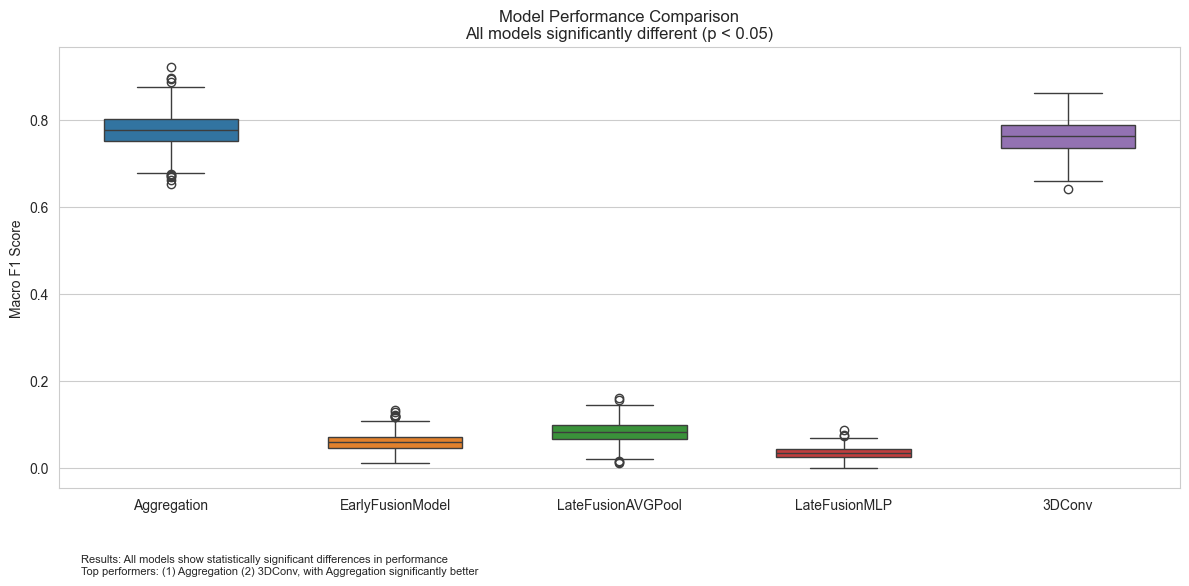

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set style and figure size
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create boxplot
sns.boxplot(data=[bootstrap_metrics[model_name] for model_name in models.keys()], 
            width=0.6)

# Customize the plot
plt.xticks(range(len(models)), models.keys())
plt.ylabel("Macro F1 Score")
plt.title("Model Performance Comparison\nAll models significantly different (p < 0.05)")

# Add text annotation explaining the results
plt.text(0.02, -0.15, "Results: All models show statistically significant differences in performance\n" + 
         "Top performers: (1) Aggregation (2) 3DConv, with Aggregation significantly better",
         transform=plt.gca().transAxes, fontsize=8, va='top')

plt.tight_layout()
plt.show()

# No leaks comparison

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets_new import FrameVideoDataset

root_dir = r"ufc10"

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running on: {device}')

# Define transforms for different model types*
transform_pretrained = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_3d = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and loaders for different model types
test_dataset_pretrained = FrameVideoDataset(root_dir=root_dir, split='val', 
                                          transform=transform_pretrained, stack_frames=True)
test_dataset_3d = FrameVideoDataset(root_dir=root_dir, split='val', 
                                   transform=transform_3d, stack_frames=True)

test_loader_pretrained = DataLoader(test_dataset_pretrained, batch_size=8, shuffle=False)
test_loader_3d = DataLoader(test_dataset_3d, batch_size=8, shuffle=False)